# 1.Setup

In [14]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras.regularizers import l2
from keras import backend as K

# 1.1 Augmentation함수 생성

In [15]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:   # training 시에
        return Compose([
                HorizontalFlip(p=0.5),
                RandomSizedCrop(
                    min_max_height=(300,370),
                    w2h_ratio=370/1242,
                    height=224,
                    width=224,
                    p=0.5
                ),Resize(
                        width=224,
                        height=224
                        )
                ])
    
    return Compose([
            Resize(
                width=224,
                height=224
                )
        ])

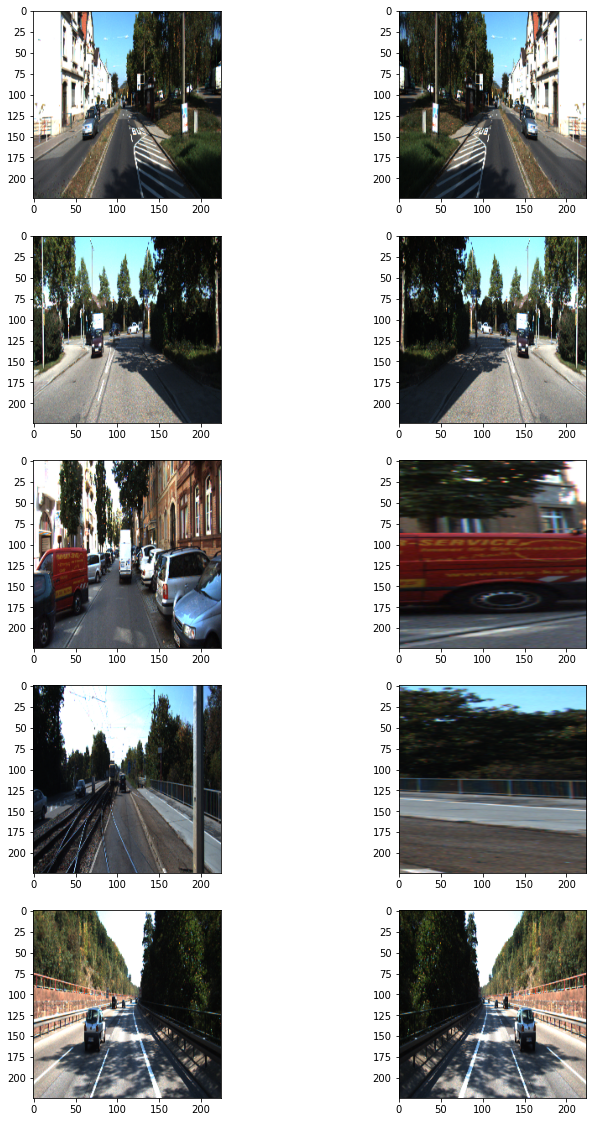

In [16]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋 Augmentation적용 sample 5개 확인
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

# 1.2 전처리 및 데이터 구축

In [17]:
class KittiGenerator(tf.keras.utils.Sequence):
    
    def __init__(self,
                 dir_path, # dataset의 directory path
                 batch_size=8, # batch size
                 img_size=(224, 224, 3), # preprocess에 사용할 입력이미지의 크기
                 output_size=(224,224), # ground_truth를 만들어주기 위한 크기
                 is_train=True, # training, test 여부
                 augmentation=None): # 적용하길 원하는 augmentation 함수
        
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.output_size = output_size
        self.augmentation = augmentation
        self.is_train = is_train

        # load_dataset()으로 Kitti dataset의 directory path에서 라벨과 이미지 확인
        self.data = self.load_dataset()
    
    def load_dataset(self):
        # Kitti dataset에서 필요한 정보(이미지 경로 및 라벨)을 directory에서 확인하고 load
        # is_train에 따라 augmentation 유무
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length. 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 augmentation과 resize가 적용된 input image
        # 출력은 sematic label
        batch_data = self.data[index*self.batch_size:
                               (index+1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented['image']/255
            outputs[i] = augmented['mask']
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수
        # 학습중인 경우에 순서를 random shuffle하도록 적용
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [18]:
augmentation = build_augmentation()
test_preprocess = build_augmentation(is_train=True)

# train_data
train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

# test_data
test_generator = KittiGenerator(
    dir_path,
    augmentation = test_preprocess,
    is_train=False
)

# 2. 모델 구성
---

### U-Net

In [92]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
    conv3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)
    
    conv4 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    #Expanding Path
    up6 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    drop6 = Dropout(0.5)(conv6)
    
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    drop7 = Dropout(0.5)(conv7)
    
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    drop8 = Dropout(0.5)(conv8)
    
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)
    drop9 = Dropout(0.5)(conv9)
    
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [93]:
model = build_model()
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 224, 224, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 224, 224, 32) 9248        conv2d_120[0][0]                 
__________________________________________________________________________________________________
dropout_23 (Dropout)            (None, 224, 224, 32) 0           conv2d_121[0][0]                 
___________________________________________________________________________________________

### U-Net++

In [87]:
# 기본 Conv block
def conv_block(inputs, stage, feature_map, kernel_size=3):
    
    x = Conv2D(feature_map, kernel_size, activation='relu',name='conv'+stage+'_1', padding='same',kernel_initializer='he_normal')(inputs)
    x = Conv2D(feature_map, kernel_size, activation='relu',name='conv'+stage+'_2', padding='same',kernel_initializer='he_normal')(x)
    drop = Dropout(0.5, name=f'drop{stage}')(x)
    
    return drop

In [88]:
def build_plus2_model(input_shape=(224, 224, 3),num_class=1,deep_supervision=False):
    inputs = Input(input_shape)
    
    feature_map=[32,64,128,256,512]
    
    conv0_0 = conv_block(inputs, stage='00', feature_map=feature_map[0])
    pool0 = MaxPooling2D(pool_size=(2, 2), name='pool0')(conv0_0)
    
    conv1_0 = conv_block(pool0, stage='10', feature_map=feature_map[1])
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1_0)
    
    up0_1 = Conv2DTranspose(feature_map[0], 2, activation='relu',name='up01', strides=(2,2), kernel_initializer='he_normal')(conv1_0)
    conv0_1 = concatenate([up0_1,conv0_0],name='merge01', axis = 3)
    conv0_1 = conv_block(conv0_1, stage='01', feature_map=feature_map[0])
    
    conv2_0 = conv_block(pool1, stage='20', feature_map=feature_map[2])
    pool2 = MaxPooling2D(pool_size=(2,2), name='pool2')(conv2_0)
    
    up1_1 = Conv2DTranspose(feature_map[1], 2, activation='relu',name='up11', strides=(2,2), kernel_initializer='he_normal')(conv2_0)
    conv1_1 = concatenate([up1_1,conv1_0], name='merge11', axis=3)
    conv1_1 = conv_block(conv1_1, stage='11', feature_map=feature_map[1])
    
    up0_2 = Conv2DTranspose(feature_map[0], 2, activation='relu', name='up02', strides=(2,2), kernel_initializer='he_normal')(conv1_1)
    conv0_2 = concatenate([up0_2,conv0_1,conv0_0], name='merge02',axis=3)
    conv0_2 = conv_block(conv0_2, stage='02', feature_map=feature_map[0])
    
    conv3_0 = conv_block(pool2, stage='30', feature_map=feature_map[3])
    pool3 = MaxPooling2D(pool_size=(2, 2),name='pool3')(conv3_0)
    
    up2_1 = Conv2DTranspose(feature_map[2], 2, activation='relu',name='up21', strides=(2,2), kernel_initializer='he_normal')(conv3_0)
    conv2_1 = concatenate([up2_1,conv2_0], name='merge21',axis=3)
    conv2_1 = conv_block(conv2_1, stage='21', feature_map=feature_map[2])
    
    up1_2 = Conv2DTranspose(feature_map[1], 2, activation='relu',name='up12', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    conv1_2 = concatenate([up1_2,conv1_1,conv1_0], name='merge12',axis=3)
    conv1_2 = conv_block(conv1_2, stage='12', feature_map=feature_map[1])
    
    up0_3 = Conv2DTranspose(feature_map[0], 2, activation='relu', name='up03',strides=(2,2), kernel_initializer='he_normal')(conv1_2)
    conv0_3 = concatenate([up0_3,conv0_2,conv0_1,conv0_0], name='merge03', axis=3)
    conv0_3 = conv_block(conv0_3, stage='03', feature_map=feature_map[0])
    
    conv4_0 = conv_block(pool3, stage='40', feature_map=feature_map[4])
    drop4_0 = Dropout(0.5)(conv4_0)
    
    up3_1 = Conv2DTranspose(feature_map[3], 2, activation='relu', name='up31', strides=(2,2), kernel_initializer='he_normal')(drop4_0)
    conv3_1 = concatenate([up3_1,conv3_0], name='merge31',axis=3)
    conv3_1 = conv_block(conv3_1, stage='31', feature_map=feature_map[3])
    
    up2_2 = Conv2DTranspose(feature_map[2], 2, activation='relu', name='up22', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
    conv2_2 = concatenate([up2_2,conv2_1,conv2_0], name='merge22',axis=3)
    conv2_2 = conv_block(conv2_2, stage='22', feature_map=feature_map[2])
    
    up1_3 = Conv2DTranspose(feature_map[1], 2, activation='relu', name='up13', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
    conv1_3 = concatenate([up1_3,conv1_2,conv1_1,conv1_0], name='merge13',axis=3)
    conv1_3 = conv_block(conv1_3, stage='13', feature_map=feature_map[1])
    
    up0_4 = Conv2DTranspose(feature_map[0], 2, activation='relu', name='up04', strides=(2,2), kernel_initializer='he_normal')(conv1_3)
    conv0_4 = concatenate([up0_4,conv0_3,conv0_2,conv0_1,conv0_0], name='merge04',axis=3)
    conv0_4 = conv_block(conv0_4, stage='04', feature_map=feature_map[0])
    
    nestnet_output_1 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_1',kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv0_1)
    nestnet_output_2 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_2',kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv0_2)
    nestnet_output_3 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_3',kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv0_3)
    nestnet_output_4 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_4',kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv0_4)
    
    if deep_supervision:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                              nestnet_output_2,
                                              nestnet_output_3,
                                              nestnet_output_4])
    else:
        model = Model(inputs = inputs, outputs=[nest_output_4])
    
    return model

In [82]:
plus_model= build_plus2_model(deep_supervision=True)
plus_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv00_1 (Conv2D)               (None, 224, 224, 32) 896         input_9[0][0]                    
__________________________________________________________________________________________________
conv00_2 (Conv2D)               (None, 224, 224, 32) 9248        conv00_1[0][0]                   
__________________________________________________________________________________________________
pool0 (MaxPooling2D)            (None, 112, 112, 32) 0           conv00_2[0][0]                   
____________________________________________________________________________________________

# 3. 모델 학습
---

### U-Net

In [94]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)

Epoch 1/100
22/22 [==============================] - 6s 188ms/step - loss: 0.6883 - val_loss: 0.6858
Epoch 2/100
22/22 [==============================] - 4s 175ms/step - loss: 0.6704 - val_loss: 0.6646
Epoch 3/100
22/22 [==============================] - 4s 176ms/step - loss: 0.4793 - val_loss: 0.3137
Epoch 4/100
22/22 [==============================] - 4s 175ms/step - loss: 0.0901 - val_loss: 0.0799
Epoch 5/100
22/22 [==============================] - 4s 175ms/step - loss: 0.0778 - val_loss: 0.0735
Epoch 6/100
22/22 [==============================] - 4s 178ms/step - loss: 0.0894 - val_loss: 0.1525
Epoch 7/100
22/22 [==============================] - 4s 180ms/step - loss: 0.0742 - val_loss: 0.2747
Epoch 8/100
22/22 [==============================] - 4s 181ms/step - loss: 0.0638 - val_loss: 0.1082
Epoch 9/100
22/22 [==============================] - 4s 178ms/step - loss: 0.0490 - val_loss: 0.0847
Epoch 10/100
22/22 [==============================] - 4s 176ms/step - loss: 0.0506 - val_lo

### U-Net++

In [83]:
# loss function

smooth=1.
def dice_coef(y_true, y_pred):
    smooth=1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (2.*intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5*tf.keras.losses.binary_crossentropy(y_true, y_pred)+dice_coef_loss(y_true, y_pred)

In [89]:
plus_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

plus_model.compile(optimizer = Adam(3e-4), loss = bce_dice_loss)
plus_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

plus_model.save(plus_model_path)

Epoch 1/100
22/22 [==============================] - 11s 359ms/step - loss: 1.3671 - output_1_loss: 0.4326 - output_2_loss: 0.3219 - output_3_loss: 0.3108 - output_4_loss: 0.3009 - val_loss: 1.3965 - val_output_1_loss: 0.5240 - val_output_2_loss: 0.4401 - val_output_3_loss: 0.2501 - val_output_4_loss: 0.1814
Epoch 2/100
22/22 [==============================] - 7s 330ms/step - loss: 1.2683 - output_1_loss: 0.4136 - output_2_loss: 0.3537 - output_3_loss: 0.2788 - output_4_loss: 0.2214 - val_loss: 0.5680 - val_output_1_loss: 0.1775 - val_output_2_loss: 0.1582 - val_output_3_loss: 0.1299 - val_output_4_loss: 0.1017
Epoch 3/100
22/22 [==============================] - 7s 334ms/step - loss: 1.7292 - output_1_loss: 0.4491 - output_2_loss: 0.4313 - output_3_loss: 0.4301 - output_4_loss: 0.4179 - val_loss: 1.0843 - val_output_1_loss: 0.3330 - val_output_2_loss: 0.3033 - val_output_3_loss: 0.2455 - val_output_4_loss: 0.2016
Epoch 4/100
22/22 [==============================] - 7s 337ms/step - los

# 4. 결과 시각화

In [77]:
# IoU 계산
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)

    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score)
    return iou_score

### U-Net 시각화 / IoU

In [95]:
# blend image 
def get_output(model, preprocess, image_path, output_path, label_path, dir_path):
    # image_path로 입력된 이미지를 입력받아 process 후 model로 inference한 결과를
    # output_path에 저장
    origin_img = imread(image_path)
    data = {"image" : origin_img}
    processed = preprocess(**data)
    output = model(np.expand_dims(processed['image']/255, axis=0))

    #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255 # 도로로 판단한 영역

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show() # 도로로 판단한 영역 시각화

    if label_path:
        label_img = imread(label_path)
        label_data = {'image':label_img}
        label_processed = preprocess(**label_data)
        label_processed = label_processed['image']
        target = (label_processed == 7).astype(np.uint8)*1 # label 중 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

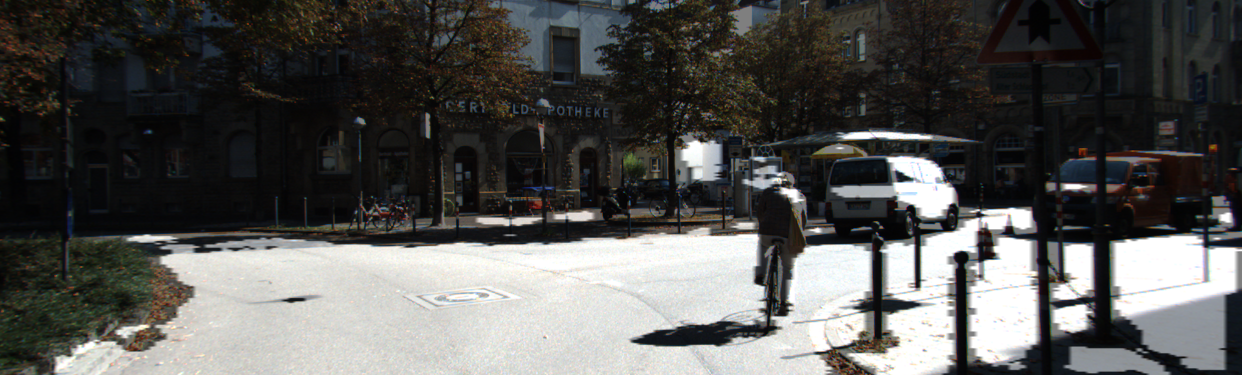

IoU : 0.620425


0.6204252577319588

In [96]:
i = 3
output, prediction, target = get_output(
    model,
    test_preprocess,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = dir_path + f'./result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    dir_path = dir_path
)

calculate_iou_score(target, prediction)

### U-Net++ 시각화 / IoU

In [85]:
# blend image show
def get_plus_output(model, preprocess, image_path, output_path, label_path, dir_path):
    # image_path로 입력된 이미지를 입력받아 process 후 model로 inference한 결과를
    # output_path에 저장
    origin_img = imread(image_path)
    data = {"image" : origin_img}
    processed = preprocess(**data)
    output = model(np.expand_dims(processed['image']/255, axis=0))
    output = np.mean([output[0],output[1],output[2],output[3]], axis=0)
    
    
    #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = (output[0]>0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255 # 도로로 판단한 영역

    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show() # 도로로 판단한 영역 시각화

    if label_path:
        label_img = imread(label_path)
        label_data = {'image':label_img}
        label_processed = preprocess(**label_data)
        label_processed = label_processed['image']
        target = (label_processed == 7).astype(np.uint8)*1 # label 중 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

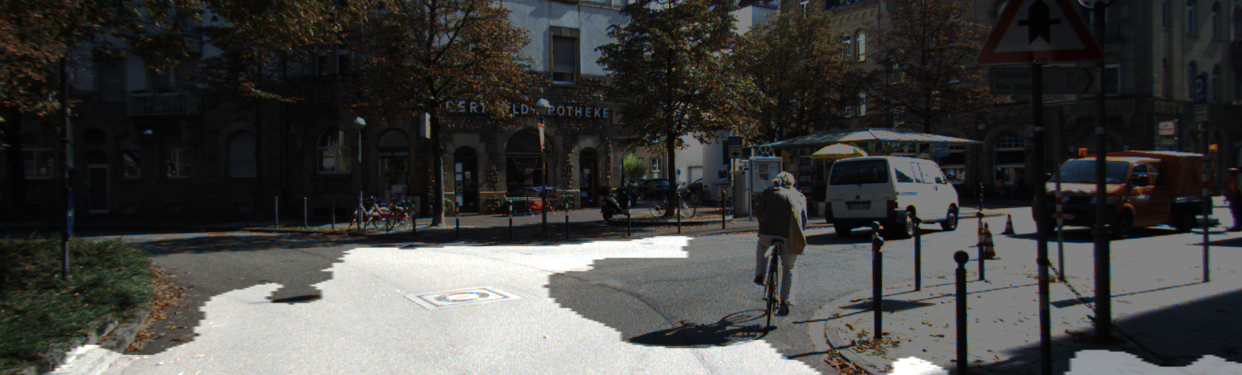

IoU : 0.488518


0.48851810441214416

In [86]:
i = 3
output, prediction, target = get_plus_output(
    plus_model,
    test_preprocess,
    image_path = dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path = dir_path + f'./plus_result_{str(i).zfill(3)}.png',
    label_path = dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
    dir_path = dir_path
)

calculate_iou_score(target, prediction)

# 5. 실험 과정

### U-Net

- 파라미터 갯수가 너무 많고, 특성 수도 많아서 Kitti데이터 셋에는 맞지않다고 판단.
    - 특성 수를 [64~1024] >>> [32,64,128,256,512]로 변경

- 2번의 conv_layer 뒤에 drop out 적용

- up-scaling시에도 drop out 적용

### U-Net++


- conv block 함수 마지막 줄에만 drop out 적용


- GPU 메모리 한계로 batch_size=8로 조정


- 특성 갯수가 많을 때 도출된 값이 e-23과 같이 굉장히 작은 값이 나옴.
- 정보 소실이 심한 것으로 판단.
    - feature map 갯수 줄여줌. [64~1024] >> [32,64,128,256,512]


- loss값 음수가 나와서 1-dice_coef를 해준 dice_coef_loss함수 사용

# 6. 실험 결과

#### 1.  U-Net++ drop out적용 여부

- Conv block과 backbone 마지막 노드에만 적용했을 때
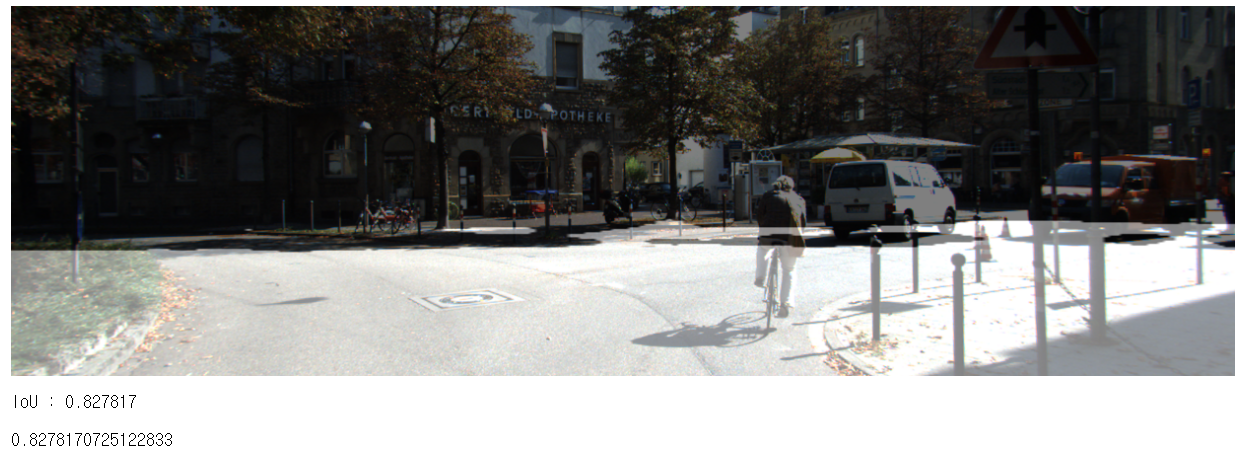


- Conv block엔 적용하지 않고 backbone 마지막 노드에만 적용했을 때
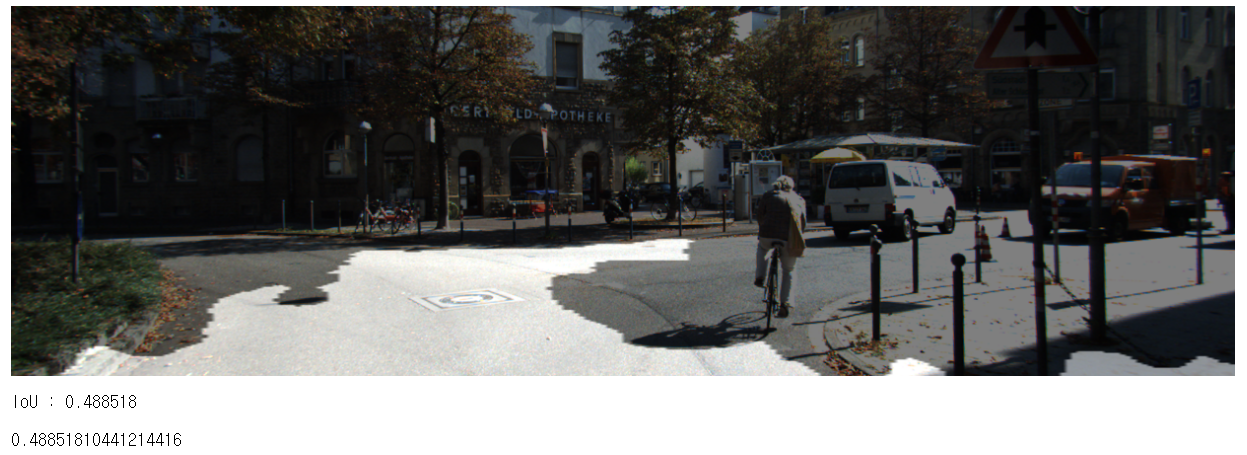

conv_block 각각에 drop out을 적용하지 않았을 때 U-Net을 통해 얻은 결과와 비슷했습니다\
그에 반면 U-Net++모델 conv_block 각각에 drop out을 적용했을 때 규제가 잘 적용되어 IoU 0.8이 넘는 거의 도로만\
segmentation 해내는 결과를 얻을 수 있었습니다.


#### 2. U-Net 특성 수 줄이기 전 후 비교

- 줄이기 전
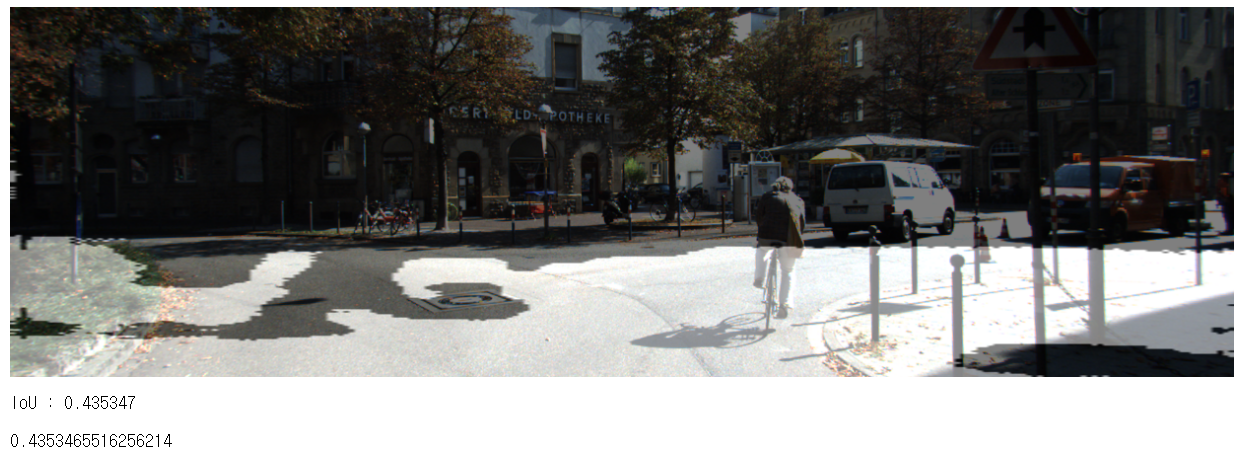


- 줄인 후
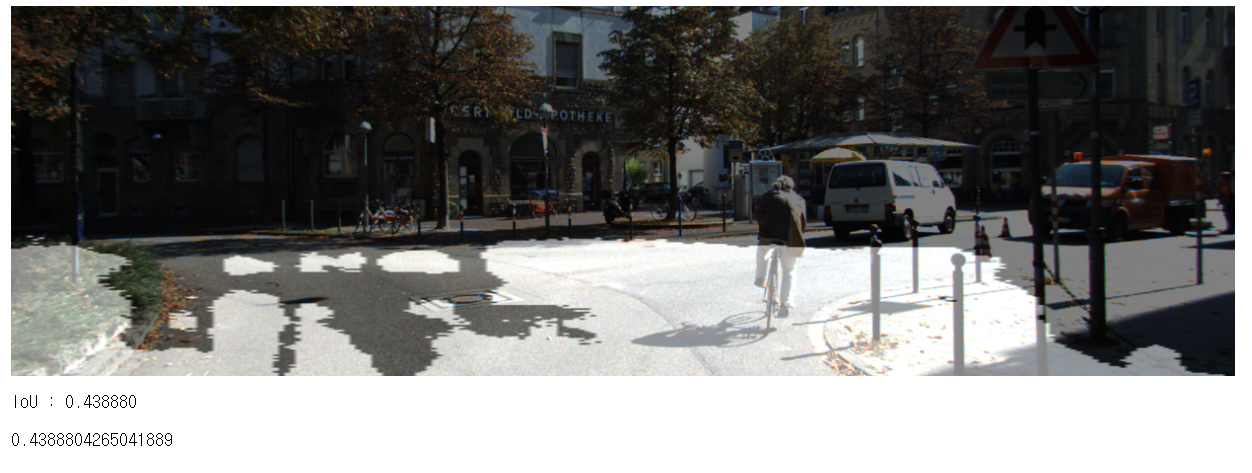

별 차이 없음. IoU가 살짝 올라간 정도. IoU값이 낮은 다른 이유가 있는 것으로 판단.

#### 3. U-Net drop_out 적용 후

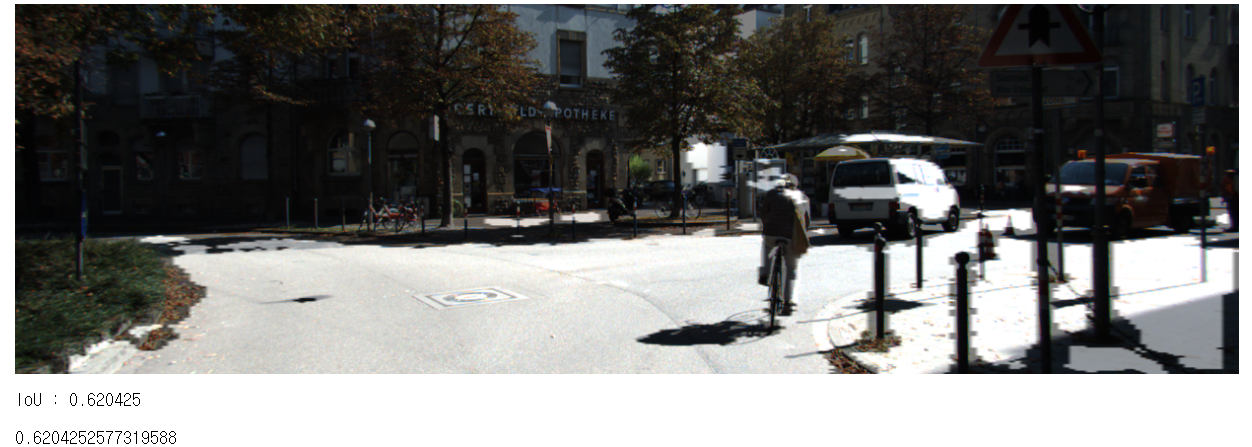

drop out 적용 후 IoU가 0.6으로 상승했습니다. 규제의 여부가 모델을 더 일반적으로 만들어주는 것 같습니다.\
하지만 길이아닌 자동차도 길로 판단한 모습이 보입니다.


#### 4. U-Net vs U-Net++


두 알고리즘을 비교해봤을 때 IoU값이 0.2가량 차이가 났습니다.(U-Net++가 더 높은 쪽으로)\
U-Net을 조금 더 최적화 한다면 더 좋은 결과를 얻을 수 있을 것 같긴 하지만,\
connect layer를 제외한 조건이 거의 같다는 것을 감안했을 때 U-Net++의 결과 보다는 안좋을 것이라는 생각이 듭니다.

아무래도 중간 connect layer로 정보 소실을 방지하며 유기적으로 결합된 이유가 크다라고 생각됩니다.

# 회고

U-Net++에서 dice_loss함수를 만들 때 binary_cross_entropy에는 마이너스를 붙이지 않고,
뒤에 dice_coef값에만 마이너스를 붙여주는 게 의아했는데, 잊고 있었던 것 중에 binary cross entropy 함수가 -ylog(y^)이기 때문에 뒤에 수식에만 마이너스를 붙여주는 것을 인지할 수 있었습니다.



